<h1>Polynomielle und lineare Regression</h1>

Nach dem Clustering ("Merge_Korrelation_Clustering.ipynb") beginnen wir mit Regressionsanalysen. Wir wollen die Infektionszahlen (AnzahlFall) in einem zeitlichen Kontext betrachten. Zunächst wird der Datensatz wieder durch Mergen erstellt.


<h1>Einlesen und Mergen der Daten</h1>

Wir teilen hier das Dataframe in vier zeitlich voneinander verschiedene Dataframes auf: Februar, März, April bis Mitte Mai und Mitte bis Ende Mai. Dieser Teil des Codes wurde nach der polynomiellen Regression hinzugefügt, die uns die zeitlichen Intervalle lieferte.

In [21]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

# CSV Datei einlesen und Dataframe erstellen
covid19 = pd.read_csv("RKI_COVID19.csv", parse_dates=['Meldedatum'], date_parser=lambda x: datetime.strptime(x, '%Y/%m/%d %H:%M:%S'))
covid19_grouped = covid19.groupby(covid19.Meldedatum).sum() 


# Merge
flaeche = pd.read_csv("Flaeche.csv", delimiter=';')
einwohner = pd.read_csv("Einwohner.csv", delimiter=';')
covid19 = pd.merge(covid19, einwohner, left_on="IdLandkreis", right_on="ID")
covid19 = pd.merge(covid19, flaeche, on="ID")

# Entferne doppelte Spalten
covid19["Kreise"] = covid19["Kreise_x"]
del covid19["Kreise_x"]
del covid19["Kreise_y"]

covid19.set_index('Meldedatum', inplace = True)
covid19.sort_index() 


#Range 1 28.01.2020 - 29.02.2020
covid19_range1 = covid19[(covid19.index > "2020/01/27 00:00:00") & (covid19.index < "2020/03/01 00:00:00")]
covid19_range1 = covid19_range1.groupby(covid19_range1.index).sum()

#Range 2 01.03.2020 - 31.03.2020
covid19_range2 = covid19[(covid19.index > "2020/02/29 00:00:00") & (covid19.index <= "2020/03/31 00:00:00")]
covid19_range2 = covid19_range2.groupby(covid19_range2.index).sum()

#Range 3 01.04.2020 - 14.05.2020
covid19_range3 = covid19[(covid19.index > "2020/03/31 00:00:00") & (covid19.index <= "2020/05/14 00:00:00")]
covid19_range3 = covid19_range3.groupby(covid19_range3.index).sum()

#Range 3 15.05.2020 - 02.06.2020
covid19_range4 = covid19[(covid19.index > "2020/05/14 00:00:00") & (covid19.index <= "2020/06/02 00:00:00")]
covid19_range4 = covid19_range4.groupby(covid19_range4.index).sum()

<h1>Polynomielle Regression</h1>

Für die polynomielle Regression wird sklearn verwendet. Wichtig sind insbesondere das Importieren von LinearRegression und PolynomialFeatures. Ein Polynom fünften Grades eignet sich am besten, um unsere Daten abzubilden. Hier gibt es nur eine Abweichung am Anfang (Tag 0 bis 20), jedoch sind in diesem Zeitraum die Infektionszahlen stabil auf einem niedrigen Niveau (mit dem Auge ersichtlich). Die Regression ermöglicht uns eine zeitliche Einteilung in vier Abschintte: Februar, März, April bis Mitte Mai und Mitte bis Ende Mai.


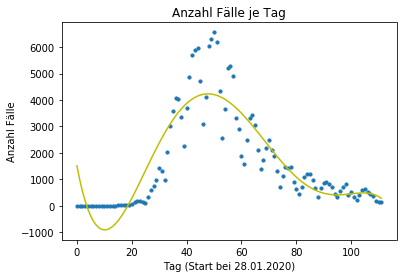

In [22]:
import operator

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

x = pd.DataFrame(covid19_grouped.index)
x = np.array(pd.to_numeric(x.Meldedatum))
x = np.array([x for x in range(112)])
y = np.array(covid19_grouped.AnzahlFall)

# transforming the data to include another axis
x = x[:, np.newaxis]
y = y[:, np.newaxis]

polynomial_features= PolynomialFeatures(degree=5)
x_poly = polynomial_features.fit_transform(x)

model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)

plt.scatter(x, y, s=10)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)
plt.plot(x, y_poly_pred, color='y')

#Beschriftung des Graphen
plt.title("Anzahl Fälle je Tag")
plt.xlabel("Tag (Start bei 28.01.2020)")
plt.ylabel("Anzahl Fälle")

plt.show()

<h1>Lineare Regression (28.01.2020 bis 01.03.2020)</h1>


Wir beschließen, die Steigung der Fallzahlen in den Abschnitten anschließend jeweils mit einer linearen Regression zu untersuchen und die Extremwerte der Kurve (entspricht einem Wechsel von fallenden zu steigenden oder steigenden zu fallenden Infektionszahlen) mit den zum jeweiligen Zeitpunkt verhängten Maßnahmen der Bundesregierung zu vergleichen.

Es wird wieder sklearn verwendet.

intercept: -10307.917433947161
slope: 6.52200000741334e-15
coefficient of determination: 0.2926051929086134
scaled slope: 0.00652200000741334


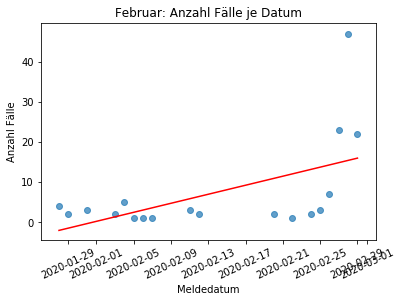

In [23]:
X = pd.DataFrame(covid19_range1.index)

y = pd.DataFrame(covid19_range1.AnzahlFall)

model = LinearRegression()
model.fit(X, y)

X_numeric = pd.DataFrame(pd.to_numeric(X.Meldedatum))
 
intercept = model.intercept_[0]
slope = model.coef_[0, 0]
scaled_slope = slope * 10**12
r_sq = model.score(X_numeric, y)
print("intercept:", intercept)
print("slope:", slope)
print("coefficient of determination:", r_sq)
print("scaled slope:", scaled_slope)
 

#Beschriftung des Graphen
plt.title("Februar: Anzahl Fälle je Datum")
plt.xlabel("Meldedatum")
plt.ylabel("Anzahl Fälle")

# Regressionsgerade hinzufügen
t = np.array([min(X_numeric.values), max(X_numeric.values)])
t = t.reshape(-1, 1)
plt.plot(np.array([pd.to_datetime(t[0]), pd.to_datetime(t[1])]), model.predict(t), "-r") #Auftragen der Regressionslinie
plt.scatter(X, y, alpha=0.7) #Auftragen der Punkte
plt.xticks(rotation=25) #Rotation der Meldedaten


plt.show()

<h1>Lineare Regression (01.03.2020 bis 31.03.2020)</h1>

intercept: -3719847.456048386
slope: 2.349364359318996e-12
coefficient of determination: 0.8372085361463594
scaled slope: 2.349364359318996


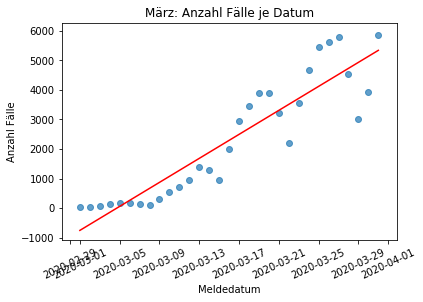

In [24]:
X = pd.DataFrame(covid19_range2.index)

y = pd.DataFrame(covid19_range2.AnzahlFall)

model = LinearRegression()
model.fit(X, y)

X_numeric = pd.DataFrame(pd.to_numeric(X.Meldedatum))
 
intercept = model.intercept_[0]
slope = model.coef_[0, 0]
scaled_slope = slope * 10**12
r_sq = model.score(X_numeric, y)
print("intercept:", intercept)
print("slope:", slope)
print("coefficient of determination:", r_sq)
print("scaled slope:", scaled_slope)
 

#Beschriftung des Graphen
plt.title("März: Anzahl Fälle je Datum")
plt.xlabel("Meldedatum")
plt.ylabel("Anzahl Fälle")

# Regressionsgerade hinzufügen
t = np.array([min(X_numeric.values), max(X_numeric.values)])
t = t.reshape(-1, 1)
plt.plot(np.array([pd.to_datetime(t[0]), pd.to_datetime(t[1])]), model.predict(t), "-r") #Auftragen der Regressionslinie
plt.scatter(X, y, alpha=0.7) #Auftragen der Punkte
plt.xticks(rotation=25) #Rotation der Meldedaten


plt.show()

<h1>Lineare Regression (01.04.2020 bis 14.05.2020)</h1>

intercept: 2019078.919450317
slope: -1.2704369274136715e-12
coefficient of determination: 0.73179232267622
scaled slope: -1.2704369274136715


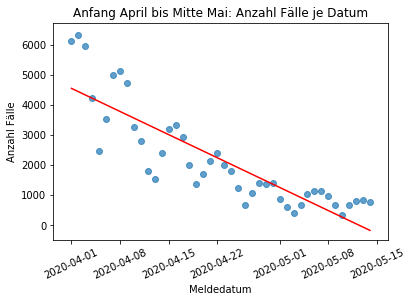

In [25]:
X = pd.DataFrame(covid19_range3.index)

y = pd.DataFrame(covid19_range3.AnzahlFall)

model = LinearRegression()
model.fit(X, y)

X_numeric = pd.DataFrame(pd.to_numeric(X.Meldedatum))
 
intercept = model.intercept_[0]
slope = model.coef_[0, 0]
scaled_slope = slope * 10**12
r_sq = model.score(X_numeric, y)
print("intercept:", intercept)
print("slope:", slope)
print("coefficient of determination:", r_sq)
print("scaled slope:", scaled_slope)
 

#Beschriftung des Graphen
plt.title("Anfang April bis Mitte Mai: Anzahl Fälle je Datum")
plt.xlabel("Meldedatum")
plt.ylabel("Anzahl Fälle")

# Regressionsgerade hinzufügen
t = np.array([min(X_numeric.values), max(X_numeric.values)])
t = t.reshape(-1, 1)
plt.plot(np.array([pd.to_datetime(t[0]), pd.to_datetime(t[1])]), model.predict(t), "-r") #Auftragen der Regressionslinie
plt.scatter(X, y, alpha=0.7) #Auftragen der Punkte
plt.xticks(rotation=25) #Rotation der Meldedaten


plt.show()

<h1>Lineare Regression (15.05.2020 bis 02.06.2020)</h1>

intercept: 371257.3578947369
slope: -2.3318713450292406e-13
coefficient of determination: 0.35205040224837547
scaled slope: -0.23318713450292405


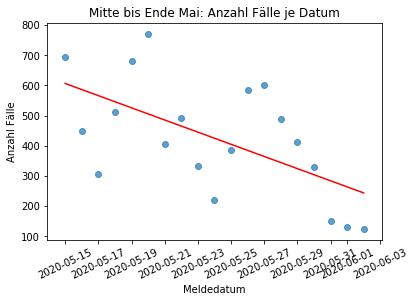

In [26]:
X = pd.DataFrame(covid19_range4.index)

y = pd.DataFrame(covid19_range4.AnzahlFall)

model = LinearRegression()
model.fit(X, y)

X_numeric = pd.DataFrame(pd.to_numeric(X.Meldedatum))
 
intercept = model.intercept_[0]
slope = model.coef_[0, 0]
scaled_slope = slope * 10**12
r_sq = model.score(X_numeric, y)
print("intercept:", intercept)
print("slope:", slope)
print("coefficient of determination:", r_sq)
print("scaled slope:", scaled_slope)
 

#Beschriftung des Graphen
plt.title("Mitte bis Ende Mai: Anzahl Fälle je Datum")
plt.xlabel("Meldedatum")
plt.ylabel("Anzahl Fälle")

# Regressionsgerade hinzufügen
t = np.array([min(X_numeric.values), max(X_numeric.values)])
t = t.reshape(-1, 1)
plt.plot(np.array([pd.to_datetime(t[0]), pd.to_datetime(t[1])]), model.predict(t), "-r") #Auftragen der Regressionslinie
plt.scatter(X, y, alpha=0.7) #Auftragen der Punkte
plt.xticks(rotation=25) #Rotation der Meldedaten


plt.show()

Der scaled slope zeigt die Steigung der jeweiligen Geraden der linearen Regression:

- Februar: leichte Steigung
- März: starke Steigung 
- April-Mitte Mai: mittelstarker Abfall
- Mitte Mai - Ende Mai: schwacherer Abfall

Diese lässt sich mit den ergriffenen Maßnahmen recht gut in Einklang bringen. Jeweils zwei Wochen vor Beginn der Zeiträume der linearen Regressionen (zwei Wochen vor den Extremwerten) gab es entweder einschränkende oder lockernde Maßnahmen.

Wir können also durch Regressionen zeigen, dass die Maßnahmen einen Einfluss auf die Entwicklung der Covid-19 Infektionszahlen in Deutschland haben.